In [142]:
from config import project_config as config
from utils.sleep_wake_filter import filter_sleep_series
import pandas as pd
from utils.data_utils import read_sleep_dairies
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    cohen_kappa_score
    )

merged_sources_path = 'Results/merged_indicators'
label = 'AWS Sleep'
models = ['pred_AWS-CNN', 'pred_PSG-CNN', 'Biobank Sleep']
sleep_diaries_path = 'data/Sleep diaries'
diaries_df = read_sleep_dairies(sleep_diaries_path).rename(columns={'participantNo': 'subject_id'})

results = pd.DataFrame()
all_preds = pd.DataFrame()
for id in config['subject_ids']:

    subject_diary = diaries_df[diaries_df['subject_id'] == id]

    df = pd.read_csv(f'{merged_sources_path}/sub_{id:02d}.csv')
    df['epoch_ts'] = pd.to_datetime(df['epoch_ts'])
    # df = df.dropna(subset=[label] + models)  # Drop epochs without a label or prediction
    df.insert(0, 'subject_id', id)
    
    # df['pred_AWS-CNN'] = filter_sleep_series(df['pred_AWS-CNN'])
    # df['pred_PSG-CNN'] = filter_sleep_series(df['pred_PSG-CNN'])
    
    # Here we mark the epochs between sleep start and sleep end as recorded in sleep diary
    # This is how it's done.
    # Create a column that's =1 for sleep_start epochs
    # Create a column that's =-1 for sleep_end epochs
    # Combine the two column so that the new "in-bed" column has a 1 when sleep start and a -1 when it ends
    # Then find the cumulative sum of the in-bed column. The cumsum will be 1 between sleep start and sleep end
    # and 0 elsewhere
    df['sleep_start'] = df['epoch_ts'].isin(subject_diary['sleep_start']).astype(int)
    df['sleep_end'] = df['epoch_ts'].isin(subject_diary['sleep_end']).astype(int).map({0: 0, 1: -1})  # Mark end of sleep with -1
    
    # merge the two columns. We can simply add them, because they are never non-zero on the same row. i.e. start timestamp and end timestamp are never the same
    df['in-bed'] = df['sleep_start'] + df['sleep_end']
    df['in-bed'] = df['in-bed'].cumsum()

    df = df.drop(columns=['sleep_start', 'sleep_end'])

    all_preds = pd.concat([all_preds, df])

    # metrics = {
    #     'F-1': f1_score,
    #     'Recall': recall_score,
    #     'Precision': precision_score,
    #     "Cohen's Kappa": lambda y_true, y_pred: cohen_kappa_score(y1=y_true, y2=y_pred),
    #     'Specificity': lambda y_true, y_pred: classification_report(y_true=y_true, y_pred=y_pred, output_dict=True, labels=[0, 1])['0']['precision']
    # }
    
#     for model in models:
#         metric_values = {metric: [] for metric in metrics.keys()}  # Placeholder for metric values
#         for metric, metric_fn in metrics.items():
#             temp_df = df.dropna(subset=[model])  # Drop epochs for which this model doesn't have an output
#             metric_value = metric_fn(y_pred=temp_df[model], y_true=temp_df[label])
#             metric_values[metric].append(round(metric_value * 100, 2))

#         metrics_df = pd.DataFrame(metric_values)
#         metrics_df.insert(0, 'Subject ID', id)
#         metrics_df.insert(1, 'Model', model)
        
#         results = pd.concat([results, metrics_df])

# results.to_csv('Metrics.csv', index=False)


In [143]:
from sklearn.metrics import classification_report
in_bed_preds = all_preds[all_preds['in-bed'] == 1]
temp_df = in_bed_preds.dropna(subset=['AWS Sleep', 'Biobank Sleep', 'pred_AWS-CNN'])
# temp_df = temp_df[temp_df['subject_id'] <= 18]
print('AWS Model')
print(classification_report(y_true=temp_df['AWS Sleep'], y_pred=temp_df['pred_AWS-CNN']))
print('Biobank')
print(classification_report(y_true=temp_df['AWS Sleep'], y_pred=temp_df['Biobank Sleep']))

AWS Model
              precision    recall  f1-score   support

         0.0       0.47      0.44      0.45     41235
         1.0       0.92      0.93      0.92    275472

    accuracy                           0.86    316707
   macro avg       0.69      0.68      0.69    316707
weighted avg       0.86      0.86      0.86    316707

Biobank
              precision    recall  f1-score   support

         0.0       0.67      0.27      0.39     41235
         1.0       0.90      0.98      0.94    275472

    accuracy                           0.89    316707
   macro avg       0.79      0.63      0.66    316707
weighted avg       0.87      0.89      0.87    316707



# PSG vs AWS

In [ ]:
from utils.data_utils import read_PSG_labels, read_AWS_labels
from config import project_config as config
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

aws_labels_path = 'data/AWS-Labels'
psg_labels_path = f'data/PSG-Labels'

psg_df = pd.DataFrame()
aws_df = pd.DataFrame()
for id in config['subject_ids'][:18]:

    subject_psg_df = read_PSG_labels(psg_labels_path, id)
    subject_psg_df.insert(0, 'subject_id', id)
    subject_psg_df['time_in_minutes'] = subject_psg_df['epoch_ts'].dt.floor('min')

    subject_aws_df = read_AWS_labels(aws_labels_path, id)
    subject_aws_df.insert(0, 'subject_id', id)

    psg_df = pd.concat([psg_df, subject_psg_df])
    aws_df = pd.concat([aws_df, subject_aws_df])

labels_df = pd.merge(
    left=psg_df,
    right=aws_df,
    left_on=['subject_id', 'time_in_minutes'],
    right_on=['subject_id', 'AWS time'],
    how='inner'
)

psg_f1 = {}
for id in config['subject_ids'][:18]:
    print(f'Subject {id}')
    temp_df = labels_df[labels_df['subject_id'] == id]
    psg_perf = classification_report(y_true=temp_df['AWS Sleep'], y_pred=temp_df['PSG Sleep'], output_dict=True)
    psg_f1[id] = psg_perf['weighted avg']['f1-score']

In [108]:
# Mismatch between PSG and AWS
labels_df['disagreement'] = (labels_df['AWS Sleep'] != labels_df['PSG Sleep']).astype(int)
labels_df.groupby('subject_id')['disagreement'].mean().sort_values()

subject_id
13    0.115481
11    0.134064
10    0.142259
7     0.149916
8     0.153589
4     0.169111
9     0.178069
14    0.180672
17    0.185000
12    0.243558
3     0.259599
18    0.261785
15    0.272422
16    0.273490
6     0.289167
1     0.295550
5     0.301084
2     0.326105
Name: disagreement, dtype: float64

# Correlating PSG's match (with AWS) to our performance

array([[1.        , 0.35641188],
       [0.35641188, 1.        ]])

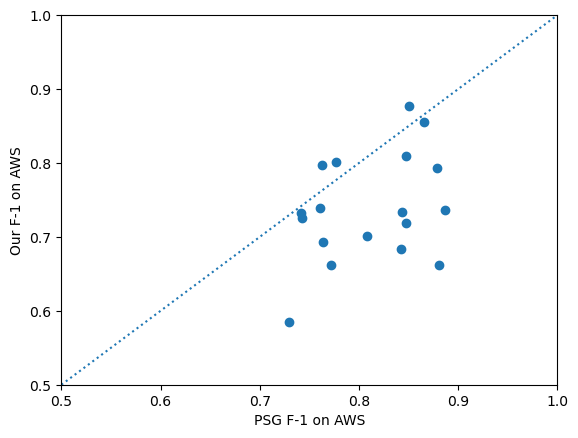

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

f1_df = pd.DataFrame.from_dict(f1, orient='index')
psg_f1_df = pd.DataFrame.from_dict(psg_f1, orient='index')
plt.scatter(psg_f1_df, f1_df)
plt.plot([0.5, 1], [0.5, 1], ls='dotted')
plt.xlim((0.5, 1))
plt.ylim((0.5, 1))
plt.xlabel('PSG F-1 on AWS')
plt.ylabel('Our F-1 on AWS')
np.corrcoef(f1_df[0], psg_f1_df[0])